In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import signal
import librosa
from sklearn.mixture import GaussianMixture

# import spcom

In [4]:
!wget http://kotoba.slp.k.hosei.ac.jp/~itou/book/2025/SpeechComm/data/CVSPtrain.tgz
!tar xzf CVSPtrain.tgz
!rm CVSPtrain.tgz

--2025-12-02 15:16:24--  http://kotoba.slp.k.hosei.ac.jp/~itou/book/2025/SpeechComm/data/CVSPtrain.tgz
kotoba.slp.k.hosei.ac.jp (kotoba.slp.k.hosei.ac.jp) をDNSに問いあわせています... 133.25.85.86
kotoba.slp.k.hosei.ac.jp (kotoba.slp.k.hosei.ac.jp)|133.25.85.86|:80 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 302 Found
場所: https://www.slp.k.hosei.ac.jp/~itou/book/2025/SpeechComm/data/CVSPtrain.tgz [続く]
--2025-12-02 15:16:24--  https://www.slp.k.hosei.ac.jp/~itou/book/2025/SpeechComm/data/CVSPtrain.tgz
www.slp.k.hosei.ac.jp (www.slp.k.hosei.ac.jp) をDNSに問いあわせています... 133.25.85.86
www.slp.k.hosei.ac.jp (www.slp.k.hosei.ac.jp)|133.25.85.86|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 1207307037 (1.1G) [application/x-gzip]
`CVSPtrain.tgz' に保存中

CVSPtrain.tgz       100%[===================>]   1.12G  1.46MB/s 時間 12m 42s    

2025-12-02 15:29:07 (1.51 MB/s) - `CVSPtrain.tgz' へ保存完了 [1207307037/1207307037]



In [ ]:
vowels = ["a", "i", "ɯ", "e", "o"]  # 対象とする母音ラベルの一覧（ここでは5母音）
CLIP_FOLDER = "./train/mp3/"  # 音声クリップ（mp3）の保存フォルダ
dfSegment = pd.read_csv(
    "FormantCVTrainShort.csv"
)  # 母音区間の情報（開始・終了時刻など）を持つCSVを読み込み
files = dfSegment["Filename"].unique()  # 登場する話者×収録単位ごとのファイル名一覧

fs = 16000  # 分析用のサンプリング周波数 [Hz]
# 20 ms をカバーするフレーム長を2のべき乗に切り上げたものを nFFT とする
# 例: fs=16000 → 0.02*fs=320 サンプル → 2^9=512 が採用される
nFFT = int(2 ** np.ceil(np.log2(0.02 * fs)))

# シフト長は 10 ms（=0.01秒）とする
nShift = int(np.round(0.01 * fs))

GMM = {}  # 各母音ごとの GMM モデルを格納する辞書
nSegment = 0  # 処理したセグメント総数のカウンタ
nMFCC = 13  # 抽出する MFCC 次元数（一般的な 13 次元）

for v in vowels:
    # この母音 v に対応する全 MFCC フレームを縦方向に積み上げていく行列
    # 形状： (nMFCC, 総フレーム数)
    mfcc = np.empty((nMFCC, 0))

    # 全てのファイルについてループ
    for f in files:
        mp3File = CLIP_FOLDER + f + ".mp3"  # mp3 ファイルパスを作成

        # このファイル f の中で、母音 v に対応する区間だけを抽出
        # Begin, End は秒単位の開始・終了時刻
        segment = dfSegment.query("Filename==@f & Vowel==@v")
        nSegment += segment.shape[0]

        # 各区間 (b: begin, e: end) ごとに処理
        for b, e in zip(segment["Begin"], segment["End"]):
            # librosa.load で該当区間のみ読み込み（offset=b, duration=e-b）
            # sr=fs としてリサンプリングし、モノラル波形 x を得る
            x, _ = librosa.load(mp3File, offset=b, duration=e - b, sr=fs)

            # プリエンファシス（高域強調）フィルタを適用
            # y[n] = x[n] - 0.97 x[n-1] に相当
            x = signal.lfilter([1, -0.97], 1, x)

            # フレーム長 nFFT より短い場合は、末尾にゼロ詰めして長さを揃える
            if len(x) < nFFT:
                x = np.concatenate([x, np.zeros((nFFT - len(x),))])

            # MFCC を計算
            # - hop_length=nShift: 10 ms シフト
            # - n_fft=nFFT: 20 ms 程度のフレーム長
            # - n_mels=40: 40 バンド Mel フィルタバンク
            # - window=np.hanning(nFFT): ハニング窓
            # - center=False: フレームの中心揃えを行わず、時系列に沿って切り出し
            # 得られる m の形状は (nMFCC, フレーム数)
            m = librosa.feature.mfcc(
                y=x,
                hop_length=nShift,
                sr=fs,
                n_fft=nFFT,
                n_mels=40,
                window=np.hanning(nFFT),
                n_mfcc=nMFCC,
                center=False,
            )

            # 0 次 MFCC（全帯域の log パワーに対応）は話者ごとの音量差など
            # 不要な変動を含みやすいため 0 に固定して捨てる
            m[0] = 0

            # 既存の mfcc 行列の右側に、今回の区間の MFCC フレームを連結
            mfcc = np.hstack((mfcc, m))

    # 母音 v に対して集めた全 MFCC フレーム（形状 (フレーム数, nMFCC)）に
    # 対し、ガウス混合モデル (GMM) を学習
    # - n_components=5: 5 成分 GMM（5 クラスタ）で音響空間を近似
    # - covariance_type='diag': 各成分の共分散を対角行列に制限（計算安定性・パラメータ削減）
    GMM[v] = GaussianMixture(n_components=5, covariance_type="diag").fit(
        mfcc.T
    )  # sklearn の実装は (サンプル数, 特徴次元) なので転置して渡す

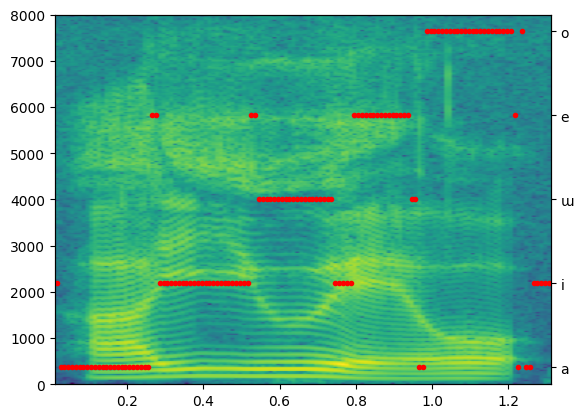

In [7]:
plt.close()

# ------------------------------------------------------------
# 1. /aiueo/ 連続母音音声の読み込みとプリエンファシス
# ------------------------------------------------------------
# - fs = 16000 Hz でリサンプリングして読み込む
# - すでに学習に使った GMM と条件を揃えるため、同じ fs, nFFT, nShift を前提としている
yAiueo, fs = librosa.load("aiueo16k.wav", sr=16000)

# 高域強調（プリエンファシス）フィルタ
#   y[n] = x[n] - 0.97 x[n-1]
# をかけることで、スペクトルの 1/f 傾斜を補正し、MFCC がフォルマント構造を捉えやすくする
yAiueo = signal.lfilter([1, -0.97], 1, yAiueo)

# ------------------------------------------------------------
# 2. 連続音声から MFCC 特徴量系列を抽出
# ------------------------------------------------------------
# - hop_length = nShift（10 ms シフト）
# - n_fft = nFFT（20 ms フレーム）
# - n_mels = 40 バンド Mel フィルタバンク
# - n_mfcc = nMFCC（学習時と同じ次元数）
# - window = ハニング窓
# - center=False: フレームを時間軸上でそのままスライドさせる（ゼロパディングによる中心合わせをしない）
m = librosa.feature.mfcc(
    y=yAiueo,
    hop_length=nShift,
    sr=fs,
    n_fft=nFFT,
    window=np.hanning(nFFT),
    n_mels=40,
    n_mfcc=nMFCC,
    center=False,
)

# ------------------------------------------------------------
# 3. 各フレームに対する「母音ごとの対数尤度」を計算
# ------------------------------------------------------------
# like の形状: (フレーム数, 母音クラス数=5)
# like[t, k] = フレーム t を母音 k の GMM で評価したときの log p(x_t | vowel_k)
like = np.zeros((m.shape[1], 5))

# GMM.keys() には vowels = ["a", "i", "ɯ", "e", "o"] が入っている想定
for vidx, v in enumerate(GMM.keys()):
    # score_samples は (サンプル数, 特徴次元) を受け取り、
    # 各サンプルの log 確率密度 log p(x) を返す。
    # m.T は (フレーム数, nMFCC) なので形状を合わせるために転置する。
    like[:, vidx] = GMM[v].score_samples(m.T)

# ------------------------------------------------------------
# 4. スペクトログラムと「フレームごとの推定母音ラベル」を同一図に重ね描き
# ------------------------------------------------------------
fig, ax1 = plt.subplots()

# 短時間フーリエ変換に基づくスペクトログラムを描画
# - NFFT, window, noverlap は MFCC 抽出時のパラメータと揃えている
# - t: 各スペクトルフレームの中心時刻 [s]
_, f, t, _ = plt.specgram(
    yAiueo,
    Fs=fs,
    NFFT=nFFT,
    window=np.hanning(nFFT),
    noverlap=nFFT - nShift,
)

# 第二の y 軸（右側）を作成して、母音ラベル系列を時間軸上に重ねる
ax2 = ax1.twinx()

# 各フレーム t について、
#   argmax(like[t, :]) で「最も尤度の高い母音クラス」を選び、
#   1〜5 の整数ラベル（縦方向位置）にマッピングしてプロットする。
# ここで +1 しているのは、インデックス 0〜4 を 1〜5 に変換し、
# y 軸目盛り（母音ラベル）と対応させるため。
ax2.plot(
    t,
    (np.argmax(like, axis=1) + 1),
    "ro",
    markersize=3,
)

# y 軸の tick を 1〜5 に取り、ラベルとして vowels の文字列を対応させる
# → スペクトログラムの上に「時刻ごとの母音クラス」が赤点で表示される
ax2.set_yticks(np.arange(1, 6), labels=vowels)

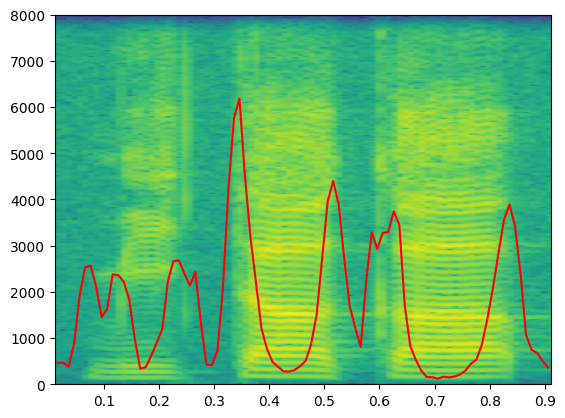

In [9]:
plt.close()

# ------------------------------------------------------------
# 1. 音声の読み込みとプリエンファシス
# ------------------------------------------------------------
# - mitaka48k.wav を fs=16000 Hz にリサンプリングして読み込む
# - すでに GMM 学習などで使ってきた条件と合わせるため、ここでも sr=16000 を指定
yMitaka, sr = librosa.load("mitaka48k.wav", sr=16000)

# プリエンファシス（高域強調）フィルタ
#   y[n] = x[n] - 0.97 x[n-1]
# によって、1/f 傾斜を補正し、高周波数帯の情報（フォルマント・摩擦音成分など）を強調する
yMitaka = signal.lfilter([1, -0.97], 1, yMitaka)

# ------------------------------------------------------------
# 2. スペクトログラム表示用の STFT パラメータ設定
# ------------------------------------------------------------
nFFT = 512  # 1 フレームあたりのサンプル数（約 32 ms）
nShift = 160  # フレームシフト（約 10 ms; 16000 Hz / 160 ≒ 100 fps）

# 短時間フーリエ変換にもとづくスペクトログラムを計算
# SMitaka: 複素スペクトル（magnitude^2 がスペクトログラムの値）
# f: 周波数軸 [Hz]
# t: 各フレームの中心時刻 [s]
SMitaka, f, t, _ = plt.specgram(
    yMitaka,
    Fs=sr,
    NFFT=nFFT,
    window=np.hanning(nFFT),
    noverlap=nFFT - nShift,
)

# ------------------------------------------------------------
# 3. MFCC の抽出
# ------------------------------------------------------------
# - hop_length=nShift: 10 ms 間隔でフレームを切り出す
# - n_fft=nFFT: 32 ms 程度のフレーム長
# - n_mels=40: 40 チャネルの Mel フィルタバンク
# - n_mfcc=13: 13 次元の MFCC を計算
# - center=False: ゼロパディングによるセンタリング無し（時間軸に忠実な開始位置）
mfcc = librosa.feature.mfcc(
    y=yMitaka,
    hop_length=nShift,
    sr=sr,
    n_fft=nFFT,
    window=np.hanning(nFFT),
    n_mels=40,
    n_mfcc=13,
    center=False,
)

# ------------------------------------------------------------
# 4. 両端フレームのパディング（デルタ計算用に 5 フレーム窓を確保）
# ------------------------------------------------------------
# この後、ΔMFCC を 5 フレーム（前後 2 フレーム＋中心 1 フレーム）の線形回帰で求める。
# そのとき、最初と最後の 2 フレームについても同じ処理を行うために、
#   [最初のフレーム, 最初のフレーム] + 元の系列 + [最後のフレーム, 最後のフレーム]
# のようにパディングしている。
#
# これにより、インデックス iColumn=2,...,N-3 のときに
#   iColumn-2 〜 iColumn+2 の 5 フレームが常に存在する状態になる。
mfcc = np.hstack(
    (
        mfcc[:, 0:1],  # 先頭フレームを1回複製
        mfcc[:, 0:1],  # さらにもう1回複製（計2フレーム）
        mfcc,  # 元の MFCC 列
        mfcc[:, -1:],  # 末尾フレームを1回複製
        mfcc[:, -1:],  # さらにもう1回複製（計2フレーム）
    )
)

# ------------------------------------------------------------
# 5. ΔMFCC（時間微分 MFCC）の計算
# ------------------------------------------------------------
# ΔMFCC を「5 フレーム分の線形回帰の傾き」として評価する。
# これは、一般的な
#   Δc_t = ( Σ_n n c_{t+n} ) / (2 Σ_n n^2)
# と同じ考え方を、最小二乗回帰の形で書き直したものとみなせる。
#
# x: 回帰に用いる説明変数行列（形状: 5×2）
#    - 1 列目: バイアス項（すべて 1）
#    - 2 列目: 時刻インデックス（-2, -1, 0, 1, 2）
#      → 傾き（2 列目の回帰係数）が「時間方向の変化量（Δ）」を表す
x = np.hstack(
    (
        np.ones((5, 1)),  # バイアス（切片）項
        np.array([np.arange(5) - 2]).T,  # -2, -1, 0, 1, 2 の時間インデックス
    )
)

# ΔMFCC を蓄積する行列（形状: 13×フレーム数）
dMFCC = np.empty((13, 0))

# 中心フレーム iColumn を 2 から (mfcc.shape[1]-3) まで動かし、
# その前後 2 フレームを含む 5 フレームで最小二乗回帰を行う。
for iColumn in np.arange(2, mfcc.shape[1] - 2):
    # y: 対象となる5フレーム分の MFCC（形状: 13×5）
    #   - 行: MFCC 次元（13 次元）
    #   - 列: 時刻インデックス -2, -1, 0, 1, 2 に対応
    y = mfcc[:, iColumn - 2 : iColumn + 3]

    # 最小二乗解 b を計算
    # b の形状: 2×13
    #   - 1 行目: 各 MFCC 次元の切片（平均レベル）
    #   - 2 行目: 各 MFCC 次元の傾き（時間変化率 = ΔMFCC の元）
    b = np.linalg.pinv(x) @ (y.T)

    # b[1:, :] は傾き（2 行目）のみ取り出しているので、形状は 1×13
    # これを転置して 13×1 の列ベクトルにし、右側に連結していく
    dMFCC = np.hstack((dMFCC, b[1:, :].T))

# ------------------------------------------------------------
# 6. ΔMFCC の大きさ（ノルム）を時間軸に沿って可視化
# ------------------------------------------------------------
# 各フレームごとに、13 次元 ΔMFCC の L2 ノルム（長さ）を計算。
# これは「そのフレームでスペクトル包絡がどれくらい変化しているか」の指標になる。
# 値が大きいフレームは、子音や遷移など変化の激しい区間であることが多い。
#
# * 100 を掛けているのは、単にプロットしたときのスケールを見やすくするための係数。
plt.plot(t, np.linalg.norm(dMFCC, axis=0) * 100, "r")

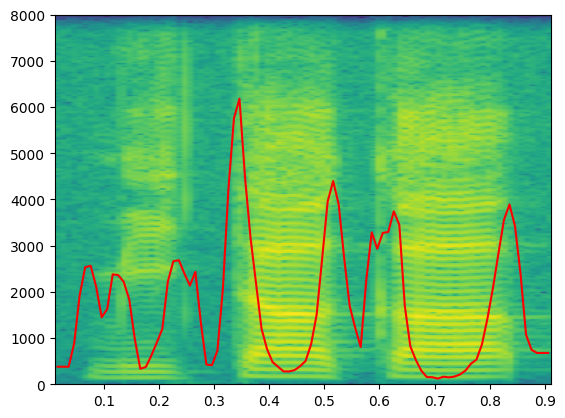

In [10]:
plt.close()

# ------------------------------------------------------------
# スペクトログラムの再描画
# ------------------------------------------------------------
# - すでに前セルで計算した yMitaka, sr, nFFT, nShift をそのまま利用
# - plt.specgram によって、時間-周波数平面上のエネルギー分布（スペクトログラム）を描画する
#   * yMitaka: プリエンファシス済み音声
#   * Fs=sr: サンプリング周波数
#   * NFFT=nFFT: 1 フレームの長さ（例: 512 サンプル ≒ 32 ms）
#   * window=np.hanning(nFFT): ハニング窓
#   * noverlap=nFFT-nShift: フレームシフトが nShift になるようにオーバーラップを設定
plt.specgram(
    yMitaka,
    Fs=sr,
    NFFT=nFFT,
    window=np.hanning(nFFT),
    noverlap=nFFT - nShift,
)

# ------------------------------------------------------------
# ΔMFCC（時間微分 MFCC）のノルムを librosa の delta 関数で計算して重ね描き
# ------------------------------------------------------------
# 前セルで手計算した ΔMFCC と同等のものを、
#   librosa.feature.delta(mfcc, width=5)
# で求め、そのノルムを時間軸上に重ねて表示する。
#
# ここでのポイント:
# - mfcc は前のセルで「前後 2 フレームを複製してパディングした形」になっている。
#   具体的には:
#       mfcc = [pad(2フレーム) | 元のMFCC列 | pad(2フレーム)]
# - width=5 は「前後 2 フレーム＋現在フレーム」の 5 フレーム窓でのデルタ計算に相当。
#   → もともとの MFCC シーケンス長と同じ長さの ΔMFCC 列が欲しいので、
#     パディング分を除いた mfcc[:, 2:-2] を delta に入力している。
#
# librosa.feature.delta の返り値の形状:
# - 入力:  (n_mfcc, T)  （ここでは 13 × T）
# - 出力:  (n_mfcc, T)  （同じ長さの ΔMFCC）
# したがって axis=0 で L2 ノルムを取ると、長さ T の 1 次元列（フレームごとの変化量）になる。
#
# また、t は specgram の戻り値（前セル）で得た各フレームの中心時刻であり、
# nShift と nFFT の設定を揃えているので、
#   - specgram の時間軸 t
#   - MFCC / ΔMFCC のフレーム列
# の対応が一致する前提になっている（長さもほぼ同じ）。
#
# 最後に *100 しているのは、プロット上で値のスケールを見やすくするための単なる係数。
plt.plot(
    t,
    np.linalg.norm(librosa.feature.delta(mfcc[:, 2:-2], width=5), axis=0) * 100,
    "r",
)

In [11]:
plt.close()

# ------------------------------------------------------------
# 音声「mitaka48k.wav」の読み込み
# ------------------------------------------------------------
# sr=16000 を指定しているので、元の 48 kHz 音声を 16 kHz にリサンプリングして読み込む。
# yMitaka: 音声波形（1 次元 numpy 配列）
# sr: サンプリング周波数 [Hz]（ここでは 16000）
yMitaka, sr = librosa.load("mitaka48k.wav", sr=16000)

# ------------------------------------------------------------
# STFT（短時間フーリエ変換）のパラメータ設定
# ------------------------------------------------------------
nFFT = 512  # 1 フレームあたりの FFT サイズ（≒ フレーム長サンプル数）
nShift = 160  # フレームシフト長（≒ 10 ms: 16000 * 0.01）

# ------------------------------------------------------------
# librosa.stft によるスペクトログラム計算
# ------------------------------------------------------------
# - yMitaka: 分析対象の音声信号
# - n_fft=nFFT: FFT 長
# - hop_length=nShift: フレームごとのシフト量
# - window=np.hanning(nFFT): ハニング窓を使用
# - center=False:
#     デフォルトではフレーム中心を基準にパディングするが、
#     center=False にすることで、時刻 t=0 から素直にフレームを切り出す。
#
# SMitaka の形状:
#   (周波数ビン数, フレーム数) = (nFFT/2+1, T)
# となり、各列が 1 フレーム分の複素スペクトルを表す。
SMitaka = librosa.stft(
    yMitaka,
    n_fft=nFFT,
    hop_length=nShift,
    window=np.hanning(nFFT),
    center=False,
)

# ------------------------------------------------------------
# フレーム中心時刻軸 t の計算
# ------------------------------------------------------------
# hop_length=nShift で STFT を計算しているので、
# フレーム k はおおよそ「時刻 k * nShift / sr」に対応する。
# ここでは単純に 0, nShift, 2*nShift, ... を sr で割って時間軸 t を生成している。
#
# len(yMitaka) サンプルぶんを nShift 間隔で刻んでいるため、
# t の長さは「切り出し可能なフレーム数」とほぼ一致する。
t = np.arange(0, len(yMitaka), nShift) / sr

# ------------------------------------------------------------
# 各フレームにおける総パワー（logPower）の計算
# ------------------------------------------------------------
# |SMitaka|**2 で各周波数ビンのパワースペクトルを求め、
# それを周波数方向に和（axis=0）をとることで、
# 各フレームにおける「全周波数帯の総パワー」（エネルギー）を求める。
#
# さらに log を取ることで、log パワー（対数エネルギー）系列 logPower を得る。
# これは MFCC で 0 次係数（C0）に対応する量と密接に関係しており、
# 発話の強さや有声/無声などの時間変化を見るときによく使われる。
logPower = np.log(np.sum(np.abs(SMitaka) ** 2, 0))

# ------------------------------------------------------------
# log パワー系列の時間微分（デルタ特徴） dLogPower の計算
# ------------------------------------------------------------
# librosa.feature.delta(logPower, width=5) は、
# 5 サンプル幅（前後 2 フレーム＋中心フレーム）の窓を使って
# 「時間方向の傾き」を近似する。
#
# 直感的には、
#   - logPower が急に増えているところ → dLogPower が大きな正の値
#   - logPower が急に減っているところ → dLogPower が大きな負の値
# となり、音圧の急激な上昇・下降（エネルギー変化）を検出する指標になる。
dLogPower = librosa.feature.delta(logPower, width=5)

# ------------------------------------------------------------
# サンプル単位の時間軸 tYMitaka の計算
# ------------------------------------------------------------
# tYMitaka は「波形 yMitaka の各サンプルが何秒に対応しているか」を
# 1 サンプルごとに計算した時間軸。
#
# 例:
#   tYMitaka[0] = 0 / sr = 0 [s]
#   tYMitaka[1] = 1 / sr
#   ...
#   tYMitaka[n] = n / sr
#
# これを使うと、波形表示と STFT 由来のフレーム単位特徴（logPower, dLogPower など）を
# 同じ時間軸上で重ねて可視化するときに便利。
tYMitaka = np.arange(len(yMitaka)) / sr